# Analysis of mobile application losses

<b>Product:</b> entertainment app Procrastinate Pro+.  
For the past few months, the business has been constantly losing money - a lot of money were invested in attracting users, but no results.  
<b>Objective:</b> Understand the reasons for this situation.  
<b>Data:</b> server's log with data on visits to the app by new users who registered between 2019-05-01 and 2019-10-27 (visits_info_short.csv), an upload of their purchases for this period (orders_info_short.csv), and statistics on advertising expenses (costs_info_short.csv).  
<b>Plan:</b> Calculate metrics (LTV, CAC, Retention rate, DAU, WAU, MAU, etc.). Analyse the results.

Table of contents:
1. [Data loading and pre-processing](#load_data)
2. [Metrics functions](#metrics)
3. [Exploratory data analysis](#eda)
4. [Marketing](#marketing)
5. [Ads return of investment (ROI)](#roi)
6. [Conclusions](#conclusion)

## <a id="load_data">Loading data and preprocessing</a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
colors = ['#002f5f', '#2c5387', '#5978b0', '#83a0d7', '#afcaff', '#ffcab9', '#fd9291', '#e75d6f', '#c52a52', '#93003a']
cat_col = ['#002f5f','#afcaff','#ffcab9','#c52a52']


In [3]:
try:
    visits, orders, costs = (
    pd.read_csv('visits_info_short.csv'),
    pd.read_csv('orders_info_short.csv'),
    pd.read_csv('costs_info_short.csv'),
)
except FileNotFoundError:
    visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),
    pd.read_csv('/datasets/orders_info_short.csv'),
    pd.read_csv('/datasets/costs_info_short.csv'),
)

In [4]:
#Visits
display(visits.head())
print(visits.info())

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None


In [5]:
# Renaming column names in accordance with snake_case
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

Based on log data the app was visited 309,901 times. There are no missing values. Datatypes should be corrected.

In [6]:
#Orders
display(orders.head())
print(orders.info())

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None


In [7]:
# Renaming columns
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

Total number of orders is 40,212. There are no missing values. Datatypes should be corrected.

In [8]:
#Costs
display(costs.head())
print(costs.info())

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None


In [9]:
#Column names to lower case
costs.columns = costs.columns.str.lower()
costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

In [10]:
costs['channel'].value_counts()

FaceBoom              180
MediaTornado          180
RocketSuperAds        180
TipTop                180
YRabbit               180
AdNonSense            180
LeapBob               180
OppleCreativeMedia    180
WahooNetBanner        180
lambdaMediaAds        180
Name: channel, dtype: int64

In [11]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


In [12]:
costs[costs['dt']=='2019-05-01']

,dt,channel,costs
0,2019-05-01,FaceBoom,113.30
180,2019-05-01,MediaTornado,6.24
360,2019-05-01,RocketSuperAds,21.06
540,2019-05-01,TipTop,80.00
720,2019-05-01,YRabbit,8.10
900,2019-05-01,AdNonSense,40.95
1080,2019-05-01,LeapBob,2.52
1260,2019-05-01,OppleCreativeMedia,4.25
1440,2019-05-01,WahooNetBanner,10.80
1620,2019-05-01,lambdaMediaAds,17.60


Total number of entries is 1,800. There are no missing values. Datatypes should be corrected.

In [13]:
# Correction of datatype in olumn with date
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [14]:
print(f'Timeframe for log data: {visits.session_start.min()} - {visits["session_end"].max()}')
print(f'Timeframe for orders data: {orders["event_dt"].min()} - {orders["event_dt"].max()}')
print(f'Timeframe for costs data: {costs["dt"].min()} - {costs["dt"].max()}')

Timeframe for log data: 2019-05-01 00:00:41 - 2019-11-01 01:38:46
Timeframe for orders data: 2019-05-01 00:28:11 - 2019-10-31 23:56:56
Timeframe for costs data: 2019-05-01 - 2019-10-27


The timeframes for available datasets closely match and are available for 6 months.

In [15]:
# duplicates check
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


<AxesSubplot:>

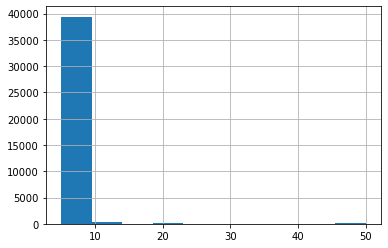

In [16]:
orders['revenue'].hist()

<AxesSubplot:>

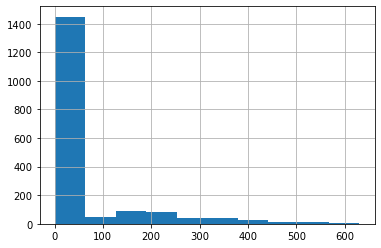

In [17]:
costs['costs'].hist()

At a first glance on the quantitative data, there are some ourliers present.

## <a id="metrics">Metrics functions</a>

In [18]:
def get_profiles(sessions, orders, ad_costs):
    """
    Extracting log data for users with the date of their first visit 
    and calculated acquisition costs based on first visit
    sessions : DataFrame with log data
    orders : DataFrame with info on placed orders
    ad_costs : DataFrame with info on expenditures on the ad campaigns
    
    returns: profiles :  DataFrame with users' first visit and acquisition cost based on the visit
    """
    # grouping log data by user id and looking into initial visits
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # date of first visit (for cohort analysis)
    profiles['dt'] = profiles['first_ts'].dt.date
    # first day of the month when the visit occured
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # if the user in the list of users who placed an order
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # unique new users per channel per first date of visit
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # combining ad costs and number of new users per channel per date
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # organic users are not connected to ads, acquisition cost for such users is zero
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

In [19]:
# calculation of retention rate
def get_retention(profiles,
                  sessions,
                  observation_date,
                  horizon_days,
                  dimensions=[],
                  ignore_horizon=False):
    """
    Calculation of retention
    profiles : DataFrame with with users' first visit and acquisition cost
    sessions : DataFrame with log data
    observation_date : timestamp
    horizon_days : int
    dimensions : list
    ignore_horizon: bool (default: False)
    
    returns:
    result_raw: profiles' subset
    result_grouped, 
    result_in_time
    """

    # name of columns that by which dataframe will be grouped
    dimensions = ['payer'] + dimensions

    # eliminating users that didn't last until the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    #adding all the sessions
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    # calculating number of days from the first session
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
    
    def group_by_dimensions(df, dims, horizon_days):
        """
        function for grouping table by necessary features
        """
        #number of unique users on the 'lifetime' day by device by payer status
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        #total amount of unique users by device by payer status
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        #proportion of users by day of a lifetime with relation to cohort size
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        #returning cohort size values
        result['cohort_size'] = cohort_sizes
        return result

    # retention table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # retention dynamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

In [20]:
def get_conversion(profiles,
                   purchases,
                   observation_date,
                   horizon_days,
                   dimensions=[],
                   ignore_horizon=False):
    """
    Calculation of conversion
    profiles : DataFrame with with users' first visit and acquisition cost
    purchases : DataFrame 
    observation_date : timestamp
    horizon_days : int
    dimensions : list
    ignore_horizon: bool (default: False)
    
    returns:
    result_raw: profiles' subset
    result_grouped, 
    result_in_time
    """
    # eliminating users that didn't last until the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # time of first purchase per user
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )


    # lifetime for every first purchase (time between first purchase and first login)
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    def group_by_dimensions(df, dims, horizon_days):
        """
        function for grouping table by necessary features
        """
        #number of unique users on the 'lifetime' day by device by payer status
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        #total amount of unique users by device by payer status
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        #proportion of users by day of a lifetime with relation to cohort size
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        #returning cohort size values
        result['cohort_size'] = cohort_sizes
        return result
    
    # conversion table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # conversion dynamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

In [21]:
def get_ltv_roi(profiles,
                purchases,
                observation_date,
                horizon_days,
                dimensions=[],
                ignore_horizon=False):
    """
    Calculation of LTV and ROI
    profiles : DataFrame with with users' first visit and acquisition cost
    purchases : DataFrame 
    observation_date : timestamp
    horizon_days : int
    dimensions : list
    ignore_horizon: bool (default: False)
    
    returns:
    result_raw: profiles' subset
    result_grouped, 
    result_in_time
    """

    # eliminating users who didn't last until the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    #adding information on their purchases
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    
    # lifetime of every purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_revenue_by_dims(df, dims, horizon_days):
        # "triangle" revenue table
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # calculating LTV: dividing revenue by cohort size
        result = result.div(result['cohort_size'], axis=0)
        
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes

        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        # mean CAC by dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # calculating ROI: dividing LTV by CAC
        roi = result.div(cac['cac'], axis=0)
        # excluding infinite ROIs
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return result, roi

    result_grouped, roi_grouped = group_revenue_by_dims(
        result_raw, dimensions, horizon_days
    )

    # for dynamics tables exclusing 'cohort' from dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # dynamics tables
    result_in_time, roi_in_time = group_revenue_by_dims(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,
        result_grouped,  # LTV
        result_in_time,  # LTV dynamics
        roi_grouped,  # ROI
        roi_in_time,  # ROI dynamics
    )

In [22]:
def filter_data(df, window):
    #applying rolling mean to every column
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [23]:
def plot_retention(retention, retention_history, horizon, colors):
    plt.figure(figsize=(15, 10))
    
    retention = retention.drop(columns=['cohort_size', 0])

    # if index contains only 'payer', adding second feature — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # retention of paying users
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, color=colors, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of paying users')

    # retention of non-paying users
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, color=colors, ax=ax2)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of non-paying users')

    # payer retention rate
    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    ).plot(grid=True, color=colors, ax=ax3)
    plt.xlabel('Date of attracting the user')
    plt.title('Payer retention rate on {}th day'.format(horizon))
    
    # non-payer retention rate
    ax4 = plt.subplot(2, 2, 4, sharey = ax3)
    retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    ).plot(grid=True, color=colors, ax=ax4)
    plt.xlabel('Date of attracting the user')
    plt.title('Non-payer retention rate on {}th day'.format(horizon))

    plt.tight_layout()
    plt.show()

In [24]:
def plot_conversion(conversion, conversion_history, horizon, colors, window=7):
    plt.figure(figsize=(15, 5))
    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # conversion
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, color=colors, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Users conversion')

    # conversion rate
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names 
        if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True,color=colors, ax=ax2)
    plt.xlabel('Date of attracting the user')
    plt.title('Conversion rate on {} day'.format(horizon))

    plt.tight_layout()
    plt.show()

In [25]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, colors, window=7):
    plt.figure(figsize=(20, 10))
    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True,color=colors, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    # ltv rate
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True,color=colors, ax=ax2)
    plt.xlabel('Date of attracting the user')
    plt.title('LTV rate on {}th day'.format(horizon))

    # cac rate
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True,color=colors, ax=ax3)
    plt.xlabel('Date of attracting the user')
    plt.title('Dynamic of the cost of attracting users')

    # roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True,color=colors, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback rate')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    # roi rate
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True,color=colors, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback rate')
    plt.xlabel('Date of attracting the user')
    plt.title('ROI rate on {}th day'.format(horizon))

    plt.tight_layout()
    plt.show()


## <a id="eda">Exploratory data analysis</a>

In [26]:
# users' profiles with info on their first session and acquisition cost
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [27]:
# Определение минимальной и максимальной даты привлечения пользователей
print('Earliest acquisition date: ', profiles['first_ts'].min())
print('Latest acquisition date: ', profiles['first_ts'].max())

Earliest acquisition date:  2019-05-01 00:00:41
Latest acquisition date:  2019-10-27 23:59:04


The values are in line with the data description and users were acquired from 2019-05-01 till 2019-10-27.

In [28]:
def analyse_profiles(df, feature):
    df_feature = df.groupby(feature).agg({'user_id': 'nunique','payer':['sum', 'mean']})
    df_feature.columns = df_feature.columns.droplevel()
    df_feature['mean, %'] = round(df_feature['mean']*100, 3)
    return df_feature

In [29]:
# number of users and payers per country, device and channel
for feature in ['region', 'device', 'channel']:
    display(analyse_profiles(profiles, feature))

,nunique,sum,mean,"mean, %"
region,,,,
France,17450,663,0.037994,3.799
Germany,14981,616,0.041119,4.112
UK,17575,700,0.039829,3.983
United States,100002,6902,0.069019,6.902


,nunique,sum,mean,"mean, %"
device,,,,
Android,35032,2050,0.058518,5.852
Mac,30042,1912,0.063644,6.364
PC,30455,1537,0.050468,5.047
iPhone,54479,3382,0.062079,6.208


,nunique,sum,mean,"mean, %"
channel,,,,
AdNonSense,3880,440,0.113402,11.340
FaceBoom,29144,3557,0.122049,12.205
LeapBob,8553,262,0.030633,3.063
MediaTornado,4364,156,0.035747,3.575
OppleCreativeMedia,8605,233,0.027077,2.708
RocketSuperAds,4448,352,0.079137,7.914
TipTop,19561,1878,0.096007,9.601
WahooNetBanner,8553,453,0.052964,5.296
YRabbit,4312,165,0.038265,3.827


* <b>Country:</b> The United States rank first in terms of the number of users and the portion of paying users. Germany has the lowest number of users, however, the number of payers is slightly higher than in the UK and France.
* <b>Device:</b> iPhone is the most popular device among users. The percentage of paying users with iPhone is lower then among Mac users by 0.15%. It is noticeable that for all the devices the percentage of paying users is around 5-6%.
* <b>Channel:</b> The number of "organic" users prevails, but the percentage of paying users among them is quite low, only 2%. The second place in the number of users is occupied by FaceBoom and this channel is the leader in the portion of paying users, 12%.

We looked at the amount of users and buyers by region, device and channel of attraction, and identified the main market. It turns out that the most users come from the USA and they convert into buyers better than others. At the same time, the majority of users come from mobile devices, this is also worth noting. Also, we can say that users who use Macs have the highest conversion rate, followed by iPhone users, i.e. we can say that in general Apple users have the best conversion rate into customers. There may be an effect from ApplePay here.


## <a id="marketing">Marketing</a>

In [30]:
print('Total amount spent on advertisement -', round(costs['costs'].sum(), 2))

Total amount spent on advertisement - 105497.3


In [31]:
# amount spent per source
costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


In [32]:
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
 3   week     1800 non-null   UInt32 
 4   month    1800 non-null   int64  
dtypes: UInt32(1), float64(1), int64(1), object(2)
memory usage: 65.2+ KB


In [33]:
costs.head()

,dt,channel,costs,week,month
0,2019-05-01,FaceBoom,113.3,18,5
1,2019-05-02,FaceBoom,78.1,18,5
2,2019-05-03,FaceBoom,85.8,18,5
3,2019-05-04,FaceBoom,136.4,18,5
4,2019-05-05,FaceBoom,122.1,18,5


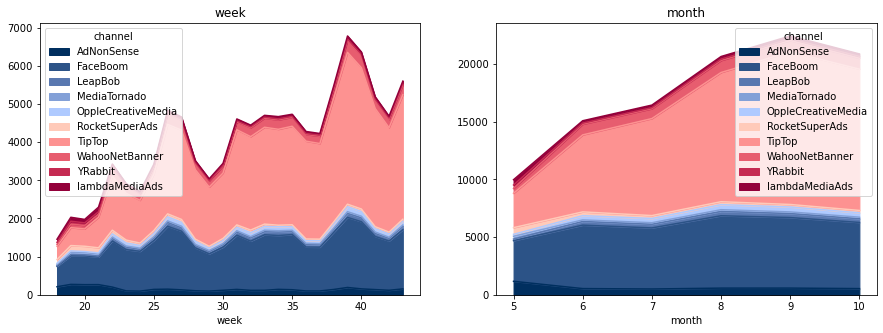

In [34]:
#spent on a weekly or monthly basis
columns = ['week', 'month']
for i, col in enumerate(columns):
    costs.pivot_table(index=col, 
                      columns='channel', 
                      values='costs', 
                      aggfunc='sum').plot.area(ax=plt.subplot(1, 2, i+1), 
                                               figsize=(15, 5), color=colors)
    plt.title(col)

In [35]:
#average CAC per user
profiles['acquisition_cost'].sum() / profiles['user_id'].count()

0.7032778251826568

In [36]:
#average CAC per channel
channel_cac = profiles.groupby('channel').agg({'acquisition_cost':['sum','count']})
channel_cac.columns = channel_cac.columns.droplevel()
channel_cac['cac'] = round(channel_cac['sum'] / channel_cac['count'], 3)
channel_cac.sort_values(by='cac', ascending=False)

,sum,count,cac
channel,,,
TipTop,54751.30,19561,2.799
FaceBoom,32445.60,29144,1.113
AdNonSense,3911.25,3880,1.008
lambdaMediaAds,1557.60,2149,0.725
WahooNetBanner,5151.00,8553,0.602
RocketSuperAds,1833.00,4448,0.412
OppleCreativeMedia,2151.25,8605,0.250
MediaTornado,954.48,4364,0.219
YRabbit,944.22,4312,0.219


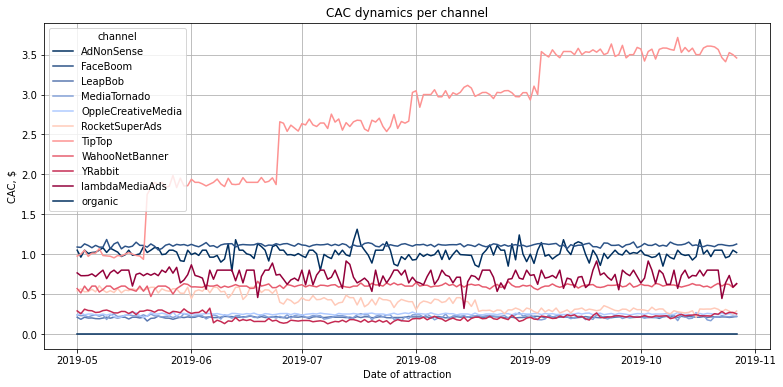

In [37]:
# CAC dynamics per channel
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(13, 6), color=colors)
plt.ylabel('CAC, $')
plt.xlabel('Date of attraction')
plt.title('САС dynamics per channel')
plt.show()

* The average cost of attracting a user is 0.7. TipTop, FaceBoom and AdNonSense channels have the highest cost per user (1 or more). 
* Almost all channels have a constant cost with slight fluctuations, while TipTop's cost gradually increases from month to month, reaching 3.5 per user in November 2019, which is 2.5 more than the other channels. 
* At the same time, the TipTop channel brought in about 10,000 fewer users than the FaceBoom channel and more than half as many “organic” users.  

The most expensive channel for attracting users is TipTop, but the number and portion of paying users coming from this source are not so high. This can be explained by TipTop's young audience and, accordingly, their solvency is not very high.

## <a id='roi'>Ads return of investment (ROI)</a>

In [38]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
# excluding "organic" users, to avoid misrepresentation of costs
profiles = profiles.query('channel != "organic"')

### Overall advertising ROI

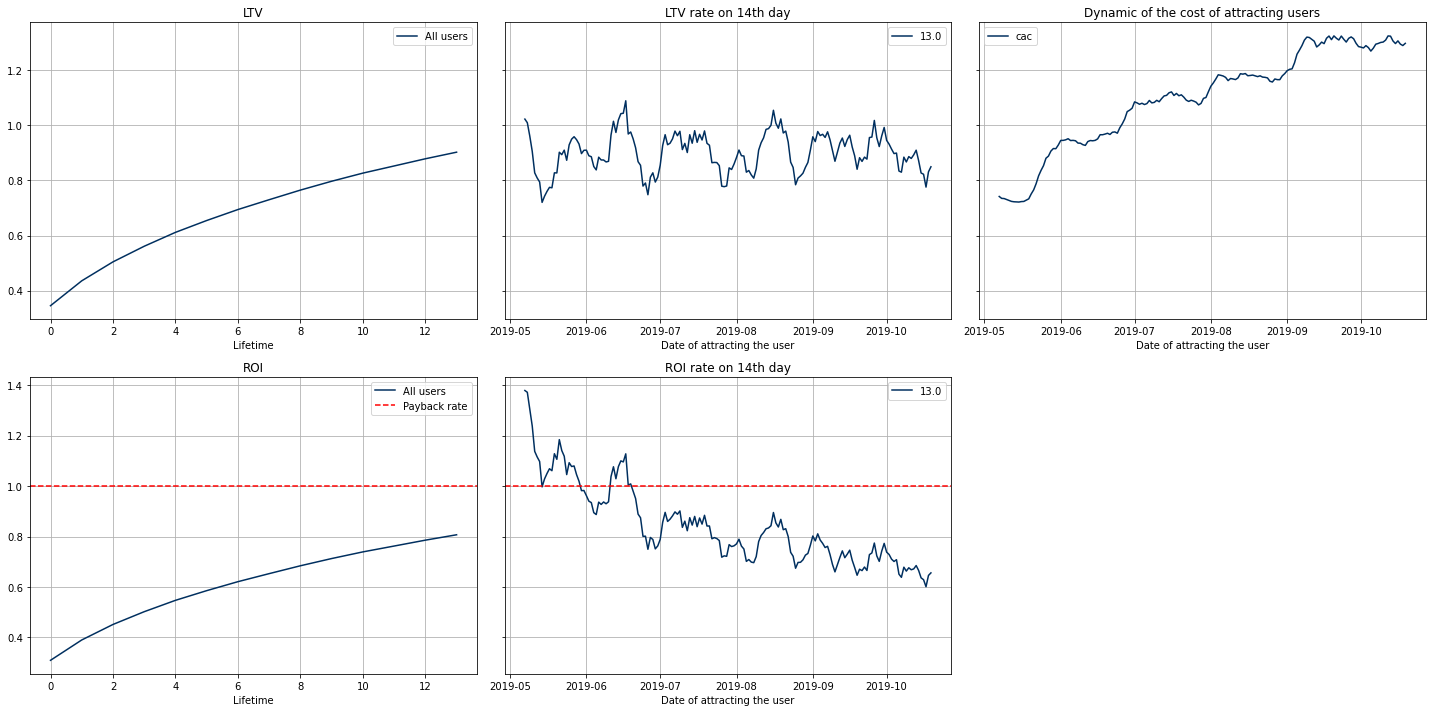

In [39]:
# LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv_roi(
    profiles, orders, observation_date, horizon_days
)

# plots
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, cat_col)

* LTV goes up as it should
* LTV on the 14th day fluctuates (peaks in the middle of the month and drops towards the end of the month), but is relatively stable for the whole period  
* CAC has an upward trend from May to the end of October, it rises steeply in the first month, but then stabilizes at the end
* ROI increases, almost reaching payback line by the end of two weeks. However, its value on the 14th day tends to decline over the time. With a strong increase in CAC, the ROI dynamics of users equally falls.


### ROI by device

In [40]:
dimensions = ['device']

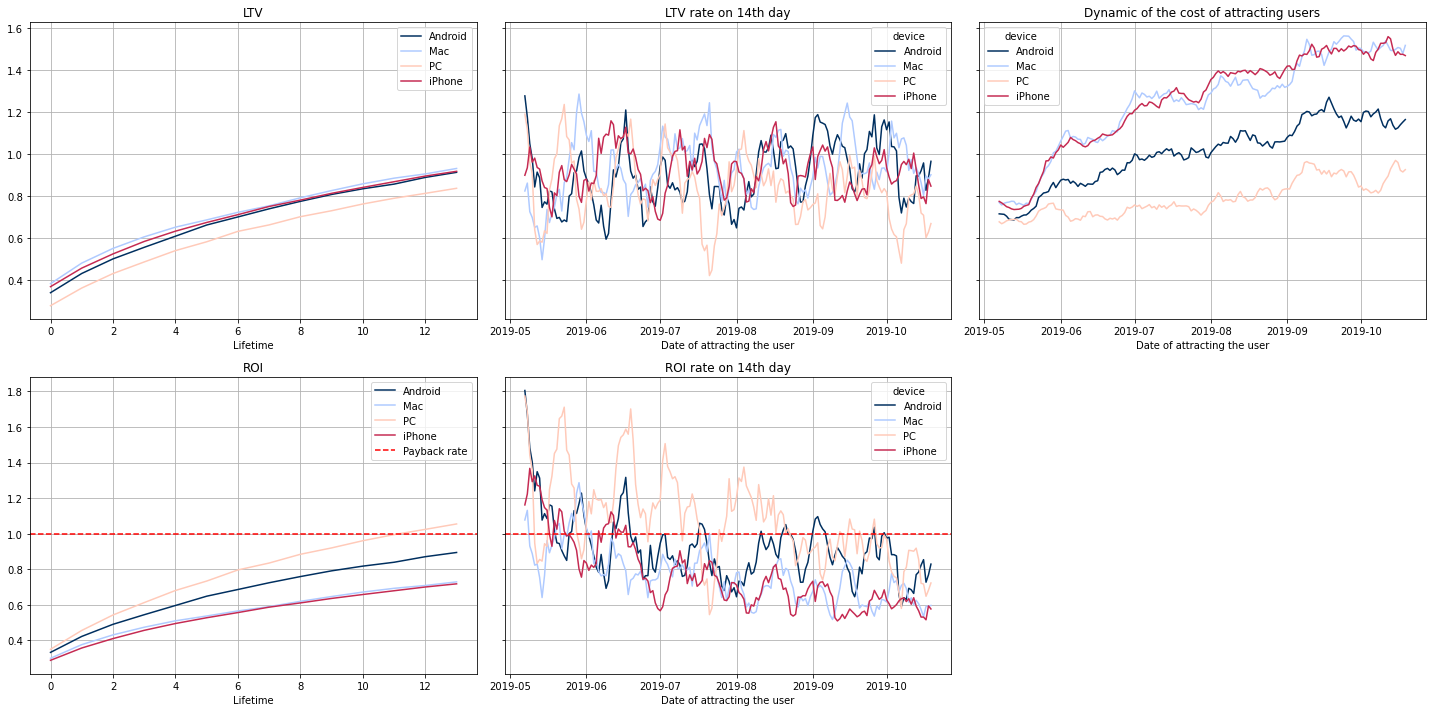

In [41]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv_roi(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, cat_col)

* The increasing trend of LTV is common for all the devices. PC users have slightly lower values
* The cost of attracting iPhone and MAC users is higher than for other devices. PC users have the lowest acquisition cost.
* ROI rises for all devices, with PC and Android surpassing the payback line

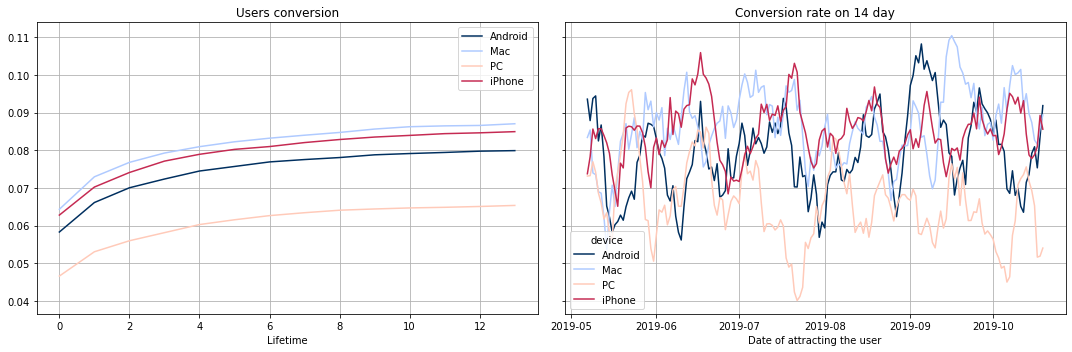

In [42]:
# user conversion by device
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, cat_col)

Apple users (iPhone and Mac) convert into buyers the best, PC users convert the worst. In general, conversion rates for all devices increase in the middle of the month. For PC users, there is a sharp drop in conversions in the middle of 2019.

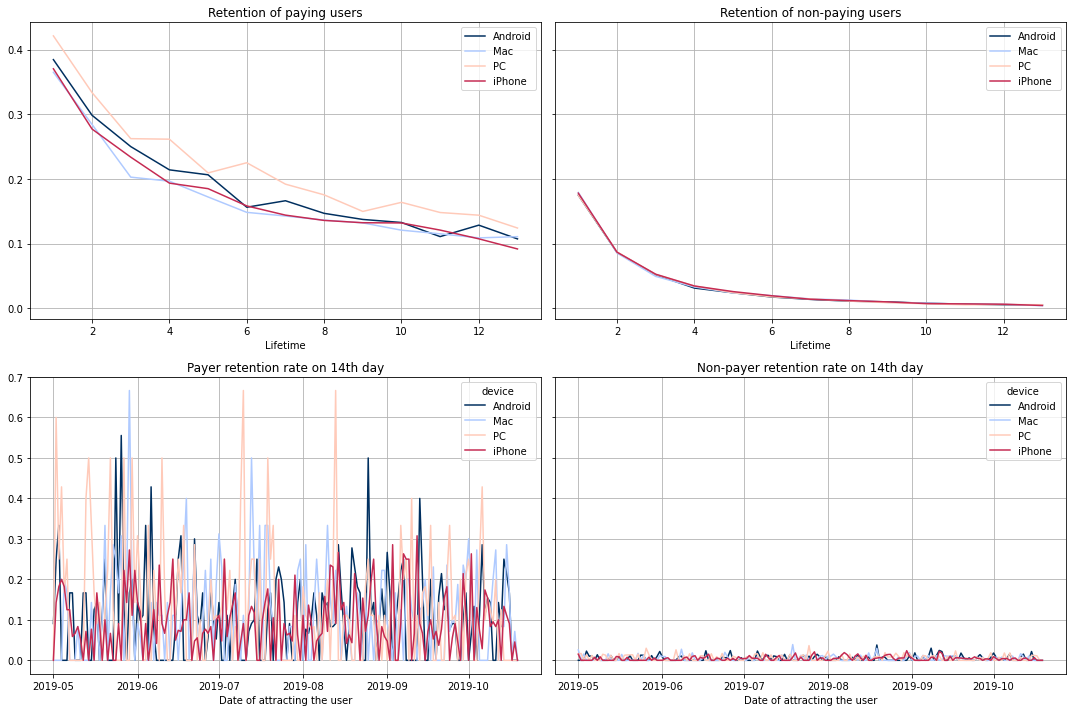

In [43]:
# retention by device
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, cat_col)

Retention of paying users is twice as much as retention of non-payers. By the 14th day amount users who hadn't bought product usually bacame 0.

### ROI by countries

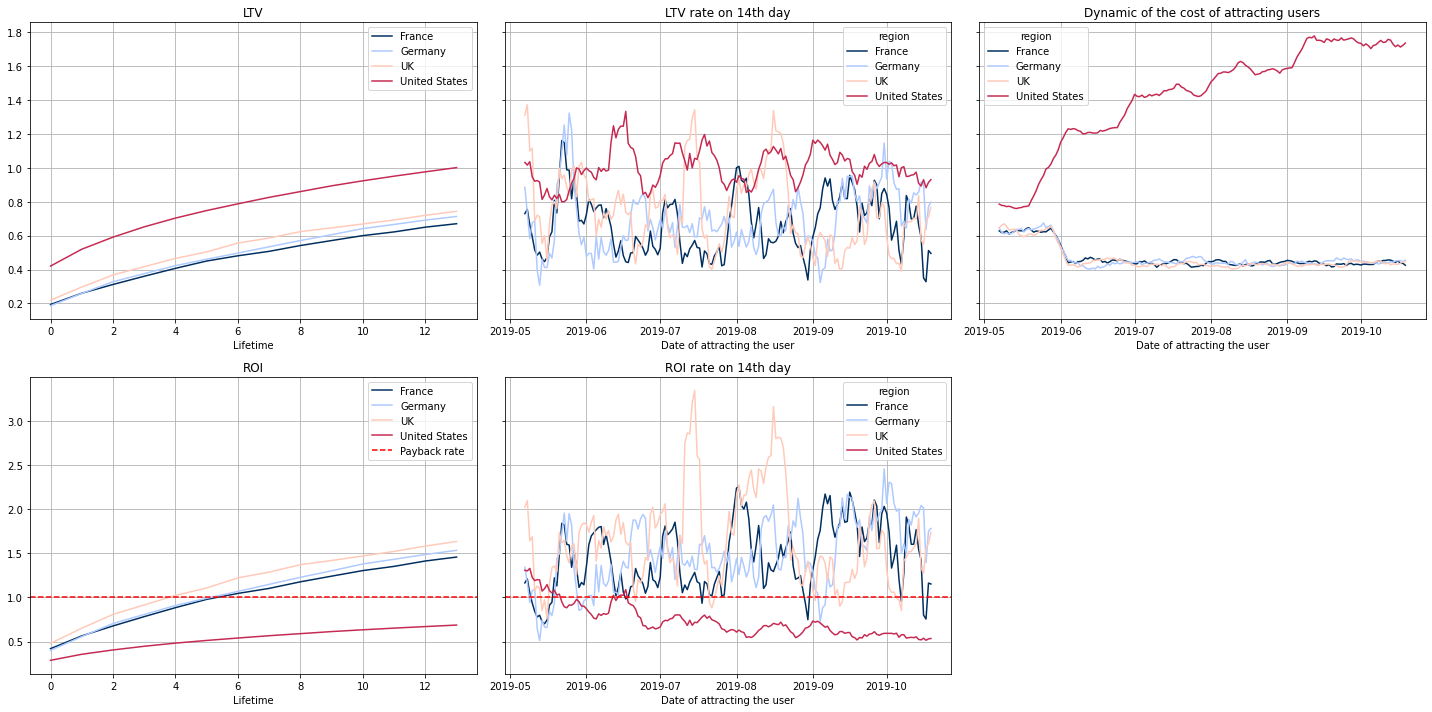

In [44]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv_roi(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, cat_col)

* Ads pay off for all the countried except for USA
* The cost of attracting US users is many times higher than for other countries. Moreover, the cost of attraction for US users grows from 0.8 to 1.7, while for the rest of the countries the cost of attraction on the contrary falls from 0.6 to 0.4.

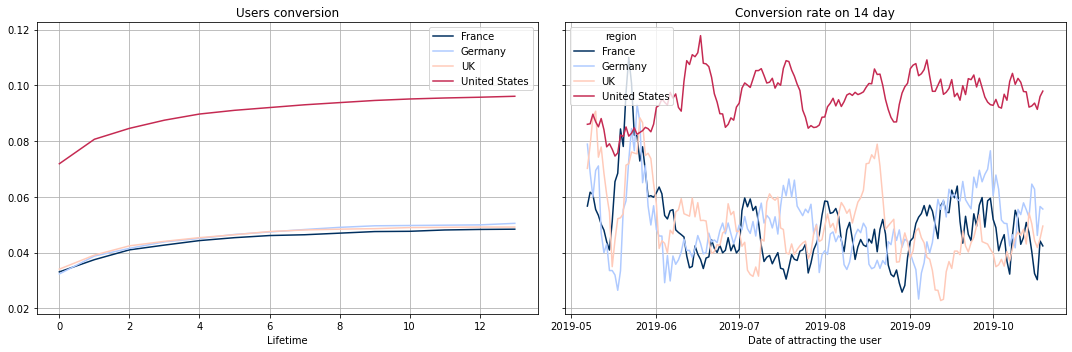

In [45]:
# conversion by countries
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, cat_col)

Users from US convert into buyers better than other countries.

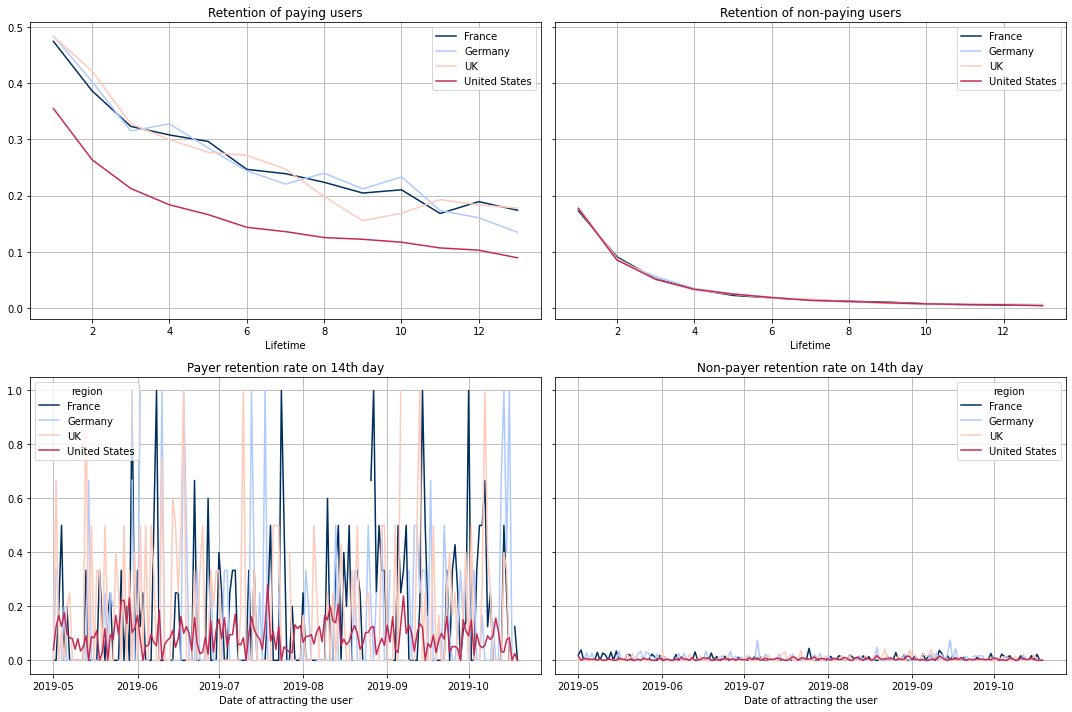

In [46]:
# retention by countries
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, cat_col)

Users from the US are retained worse than users from other countries by about 5-10%.

### ROI by channel

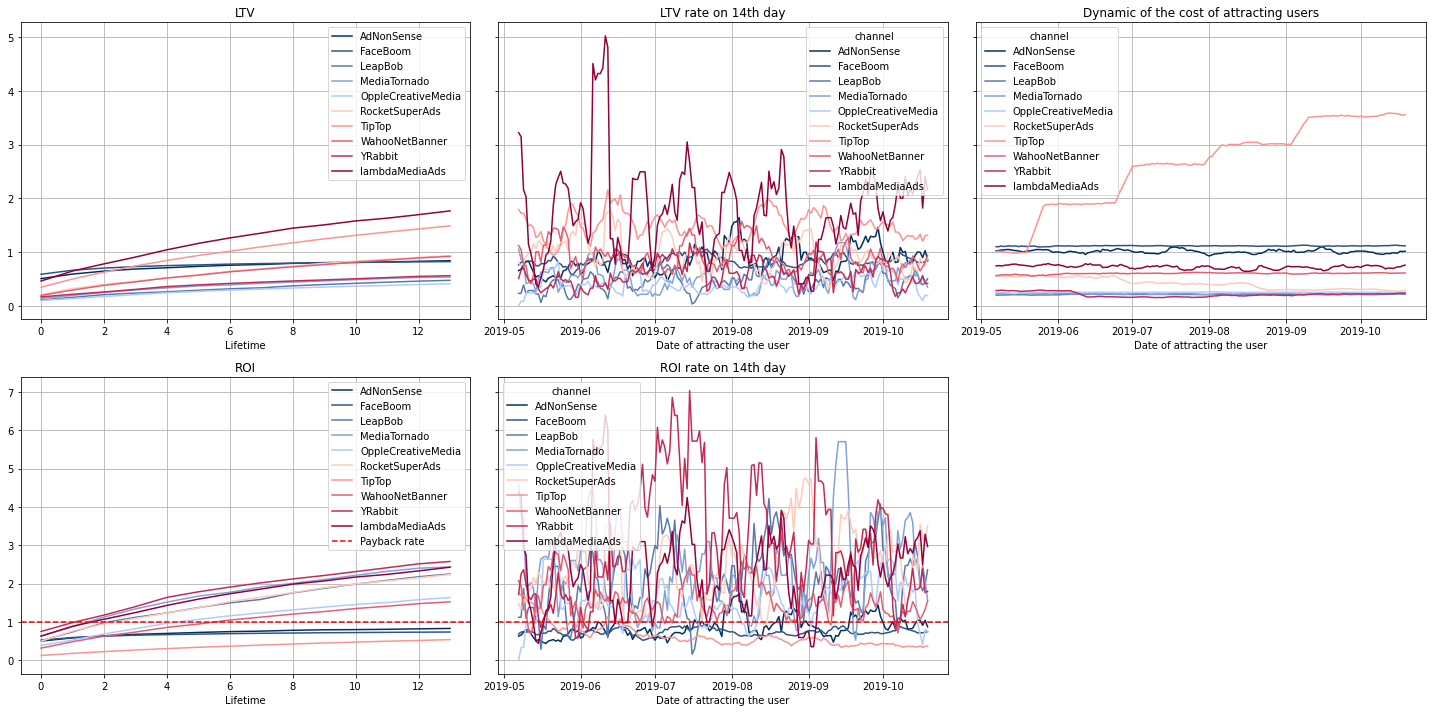

In [47]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv_roi(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, colors)

* AdNonSense, FaceBoom and TipTop channels do not pay off
* Acquisition cost per channel remains constant over the entire period, except for TipTop, whose cost grows gradually every month.


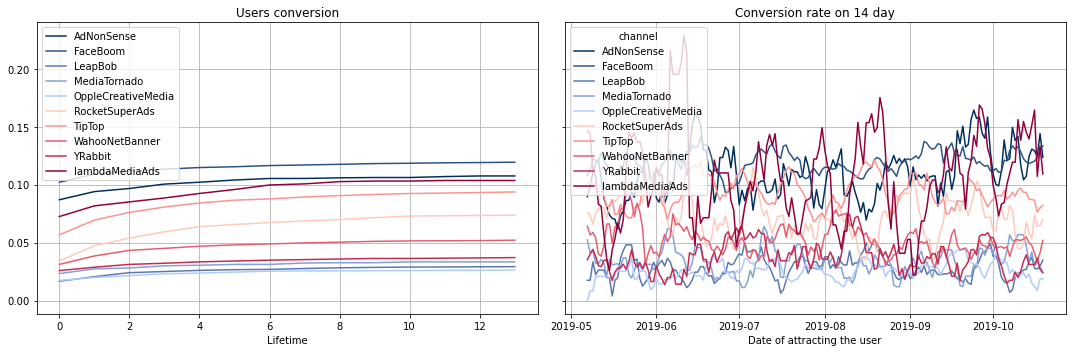

In [48]:
# coversion by channel
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, colors)

The FaceBoom channel ranks first in conversions, followed by AdNonSense and lambdaMediaAds.

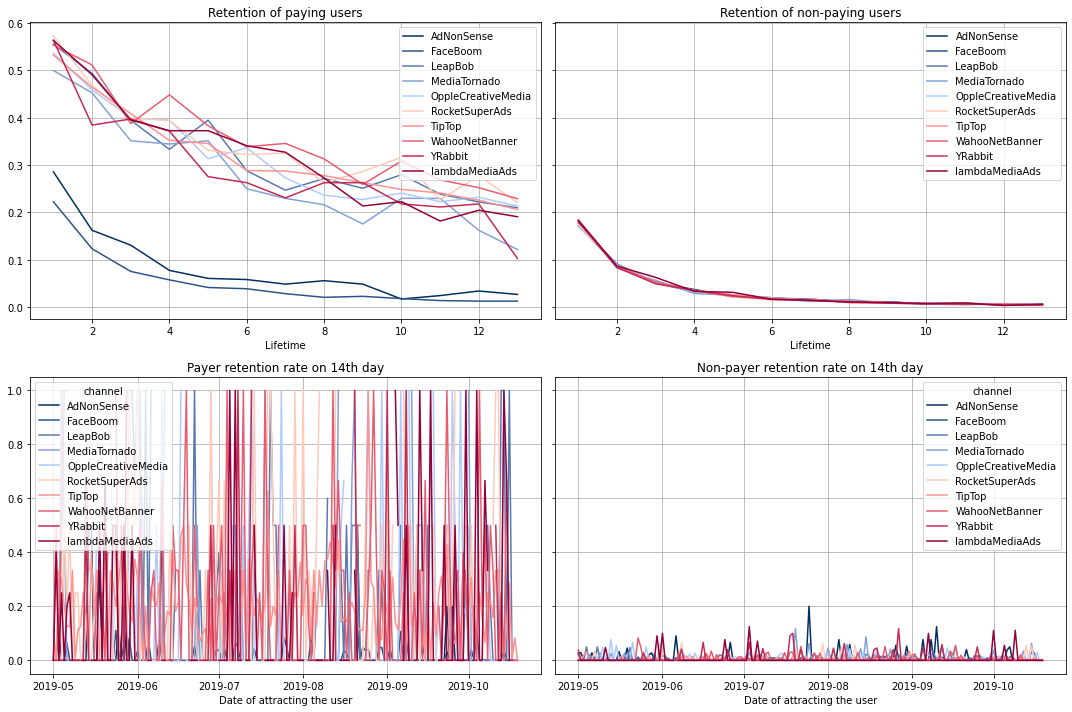

In [49]:
# retention by channel
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, colors)

Paying users attracted by AdNonSense and Faceboom were retained worse than others by about 10-20%.

Devices:
* Advertising pays off for PC users. Apple users (iPhone and Mac) convert better into buyers, and PC users convert the worst.
* The cost of attracting PC users is lower than for other devices.

Countries:
* Advertising pays off for users from France, Germany and the UK. The cost of attracting those users is also lower than from the US.

Channels:
* Advertising through AdNonSense, FaceBoom and TipTop channels does not pay off.
* Acquisition cost gradually increases for users attracted through TipTop

We can also see that high conversion does not mean high user retention:
Apple users (iPhone and Mac), US residents attracted through FaceBoom and AdNonSense channels convert best. And these are the same users who are retained the worst.

## <a id='conclusion'>Conclusions</a>

Overall, advertising does not pay off.
The cost of attracting US-based iPhone and Mac users attracted by AdNonSense, FaceBoom and TipTop tend to reduce the ROI.

Moreover, the cost of advertising on TipTop is significantly higher. The company has spent 54,751 on advertising on this channel over the entire time, which is tens of thousands of times more than the cost of other channels. On this basis, it is recommended to refuse TipTop's services.  

Moreover, the pattern of 'high conversion and low retention' is concerning. The issue indicates a need for strategies that not only attract users but also keep them engaged. Focusing on cost-effective acquisition strategies and improving user retention, especially in regions and devices with lower retention rates, can enhance overall profitability and ROI.  

The company should pay attention to PC users from European countries; and not to forget about the organic flow, as it shows rather high values in terms of the number of attracted users. RocketSuperAds channel, for example, which is in the 3rd place in terms of LTV, is not expensive in terms of price per user, has a good conversion rate and has quite good user retention rates, should be looked at.  
